# Visualization of Loan Thresholds For FICO Data

In this notebook, we visualize the positions of the loan thresholds resulting from bank Profit Maximization under various Fairness Criteria. We compare this value with the threshold on the disadvantaged population experiencing Improvement or Decline.

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import all of our files
import sys
sys.path.append('../')

import fico
import distribution_to_loans_outcomes as dlo
import support_functions as sf

DATA_DIR = '../data/'

Populating the interactive namespace from numpy and matplotlib


/home/michal/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [18]:
# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

# 0. Load and parse data

In [19]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);

../fico.py:63: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  cdfs = cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[0]))
../fico.py:64: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  performance = 100 - cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[1]))
../fico.py:28: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  frame = cleanup_frame(pd.DataFrame.from_csv(data_dir + FILES['overview']))


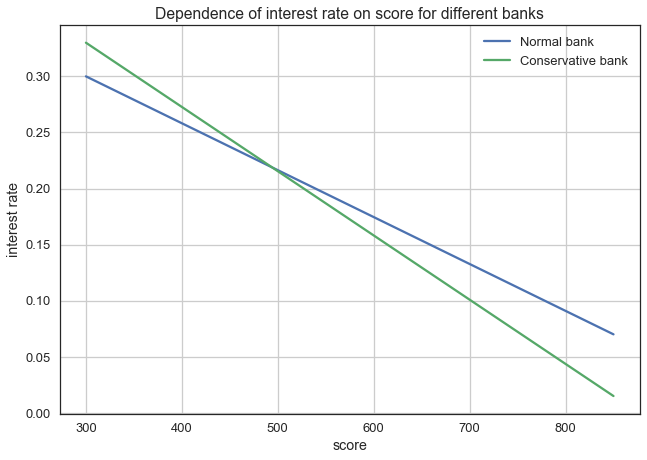

494.117647059


In [20]:
# xxx1 = normal bank
# xxx2 = conservative bank

cdfs = all_cdfs[["White","Black"]]

cdf_B1 = cdfs['White'].values

cdf_A1 = cdfs['Black'].values
cdfs1 = [cdf_A1.copy(), cdf_B1.copy()]
#Added
#Create second CDF for scores with more conservative rating

cdfs2 = [cdf_A1.copy(), cdf_B1.copy()]
conservative_dist_shift = 0.05
cumulated_diff = [0,0]

for i in range(0, len(cdfs2[0])-1):
    tmp_dif1 = cdfs2[0][i+1]-cdfs2[0][i]
    cumulated_diff[0] = tmp_dif1*conservative_dist_shift + cumulated_diff[0]
    
    if cdfs2[0][i] + cumulated_diff[0] + tmp_dif1 * conservative_dist_shift <= 1:
        cdfs2[0][i] = cdfs2[0][i] + cumulated_diff[0] + tmp_dif1 * conservative_dist_shift
    else:
        cdfs2[0][i] = 1
        
    tmp_dif2 = cdfs2[1][i+1]-cdfs2[1][i]
    cumulated_diff[1] = tmp_dif2*conservative_dist_shift + cumulated_diff[1]
    
    if cdfs2[1][i] + cumulated_diff[1] + tmp_dif2 * conservative_dist_shift<= 1:
        cdfs2[1][i] = cdfs2[1][i] + cumulated_diff[1] + tmp_dif2 * conservative_dist_shift
    else:
        cdfs2[1][i] = 1

cdfs2[0][len(cdfs2[0])-1] = 1        
cdfs2[1][len(cdfs2[1])-1] = 1
    
cdf_A2= cdfs2[0].copy()
cdf_B2= cdfs2[1].copy()
        
repay_A = performance['Black']
repay_B = performance['White']


scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index

#bank interest rate setting
score_range=[300,850]
interest_range_normal_bank=[0.3, 0.07]
interest_range_conservative_bank=[0.33, 0.015]

plt.plot(score_range,interest_range_normal_bank, label='Normal bank')
plt.plot(score_range,interest_range_conservative_bank, label='Conservative bank')
plt.ylabel('interest rate')
plt.xlabel('score')
plt.title('Dependence of interest rate on score for different banks')
plt.grid()
plt.legend(loc="upper right")
plt.show()

a1= array([score_range[0],interest_range_normal_bank[0]])
a2= array([score_range[1],interest_range_normal_bank[1]])
b1= array([score_range[0],interest_range_conservative_bank[0]])
b2= array([score_range[1],interest_range_conservative_bank[1]])
interest_intersect= sf.seg_intersect(a1,a2,b1,b2)
score_interest_intersect = interest_intersect[0]
print(score_interest_intersect)


weighted mean 651.305025791
[ 1.  1.]
[ 1.  1.]
[ 1.  1.]
[ 1.  1.]
[ 1.  1.]
weighted mean 638.310692233
34 490.769230769 494.615384615
0.51807
38 0.4876
1.00567
34 490.769230769 494.615384615
0.854395
37 0.1484
1.002795
[ 0.12066905  0.87933095]


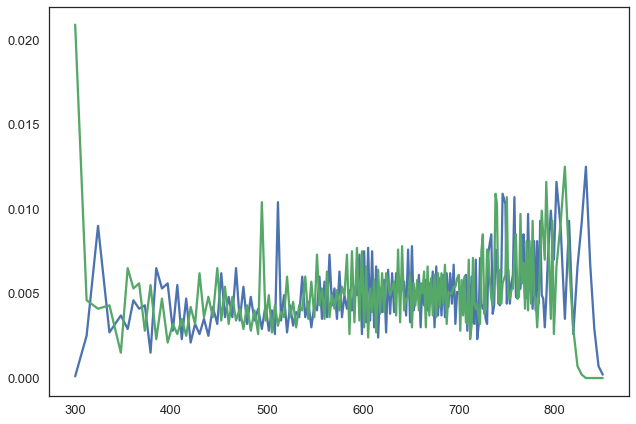

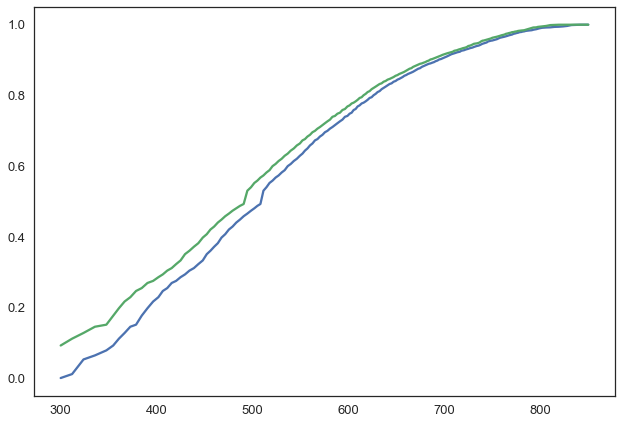

In [21]:
# to get loan repay probabilities for a given score
loan_repaid_probs = [lambda i: repay_A[scores[scores.get_loc(i,method='nearest')]], 
                     lambda i: repay_B[scores[scores.get_loc(i,method='nearest')]]]

# basic parameters
N_scores = cdf_B1.size
N_groups = 2

# get probability mass functions of each group
pi_A1 = sf.get_pmf(cdf_A1)
pi_B1 = sf.get_pmf(cdf_B1)
pi_A2 = sf.get_pmf(cdf_A2)
pi_B2 = sf.get_pmf(cdf_B2)
pis1 = np.vstack([pi_A1, pi_B1])
pis2 = np.vstack([pi_A2, pi_B2])

plt.figure(1)
plt.plot(scores,pis1[1])

#weighted score
mean = 0
for i in range(0,len(scores)):
    mean += scores[i]*pis1[1][i]
print("weighted mean " + str(mean))


new_pis = sf.get_shifted_score_distributions(pis1, -1, 5)
#weighted score
mean = 0
for i in range(0,len(scores)):
    mean += scores[i]*new_pis[1][i]
print("weighted mean " + str(mean))

plt.plot(scores,new_pis[1])


pi_combined_A = sf.get_pi_combined(pi_A1,pi_A2, scores, score_interest_intersect)
pi_combined_B = sf.get_pi_combined(pi_B1,pi_B2, scores, score_interest_intersect)
pis_combined = np.vstack([pi_combined_A, pi_combined_B])
cdf_combined_A = sf.pis2cdf(pi_combined_A)
cdf_combined_B = sf.pis2cdf(pi_combined_B)

# demographic statistics 
group_ratio = np.array((totals["Black"], totals["White"]))
group_size_ratio = group_ratio/group_ratio.sum()
print(group_size_ratio)

new_cdf=sf.pis2cdf(new_pis[0])
plt.figure(2)
plt.plot(scores, cdf_A1)
plt.plot(scores, new_cdf)

## Set Profit and Impact Parameters

In [22]:
# profit and impact
utility_repaid_1 = 1
utility_default_1 = -4
utility_repaid_2 = 1
utility_default_2 = -10

score_change_repay = 75
score_change_default = -150


# considering several utility ratios to understand sensitivity of qualitative results
util_repay = [[utility_default_1,utility_repaid_1], [utility_default_2,utility_repaid_2]]

impact=[score_change_default,score_change_repay]

# 1. Visualize Repay Probabilities from the data

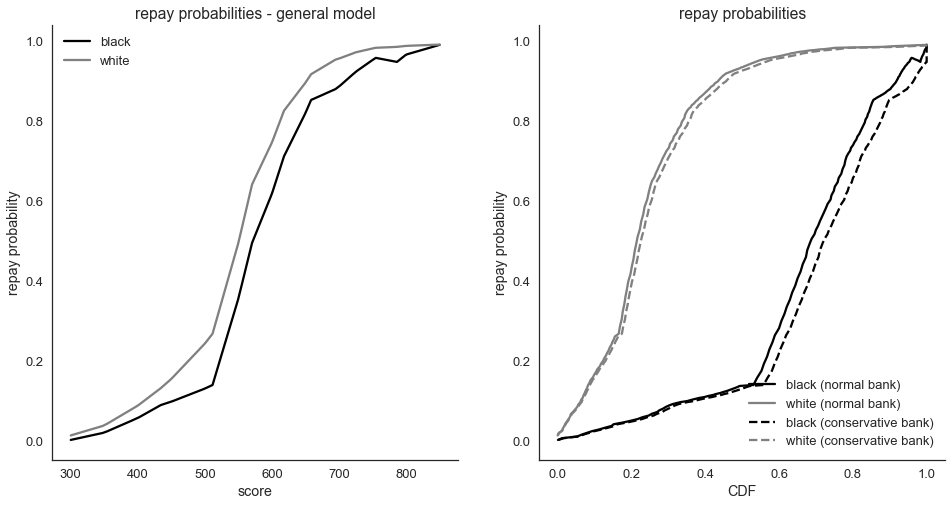

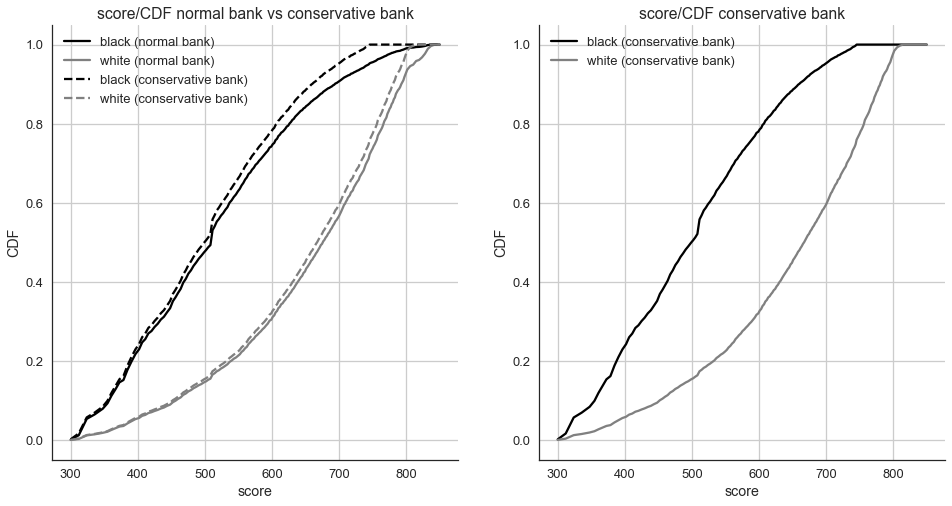

In [23]:
# plot the repay probabilities
fig, ax = plt.subplots(1,2,figsize=(16,8)); 

#there is general mapping from score to probability
ax[0].plot(scores_list,repay_A,color='black',label='black')
ax[0].plot(scores_list,repay_B,label='white',color="grey")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title("repay probabilities - general model")
ax[0].set_xlabel("score")
ax[0].set_ylabel("repay probability")
ax[0].legend()

ax[1].plot(cdf_A1,repay_A,color='black',label='black (normal bank)')
ax[1].plot(cdf_B1,repay_B,color="grey", label='white (normal bank)')
ax[1].plot(cdf_A2,repay_A,'--',color='black',label='black (conservative bank)')
ax[1].plot(cdf_B2,repay_B,'--',color="grey", label='white (conservative bank)')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title("repay probabilities")
ax[1].set_xlabel("CDF")
ax[1].set_ylabel("repay probability")
ax[1].legend()

fig, ax = plt.subplots(1,2,figsize=(16,8)); 
ax[0].plot(scores_list,cdf_A1,color='black',label='black (normal bank)')
ax[0].plot(scores_list,cdf_B1,color="grey", label='white (normal bank)')
        
ax[0].plot(scores_list,cdfs2[0],'--',color='black',label='black (conservative bank)')
ax[0].plot(scores_list,cdfs2[1],'--',color="grey", label='white (conservative bank)')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title("score/CDF normal bank vs conservative bank")
ax[0].set_xlabel("score")
ax[0].set_ylabel("CDF")
ax[0].legend()
ax[0].grid()

ax[1].plot(scores_list,cdfs2[0],color='black',label='black (conservative bank)')
ax[1].plot(scores_list,cdfs2[1],color="grey", label='white (conservative bank)')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title("score/CDF conservative bank")
ax[1].set_xlabel("score")
ax[1].set_ylabel("CDF")
ax[1].legend()
ax[1].grid()
    

# 2. Compute thresholds and visualize on group CDFs

In [24]:
threshes1 = []
threshes2 = []
for utils in util_repay:
    threshes1.append(dlo.get_thresholds(loan_repaid_probs, pis1, group_size_ratio,
                                                utils, impact, scores_list))
    threshes2.append(dlo.get_thresholds(loan_repaid_probs, pis1, group_size_ratio,
                                                utils, impact, scores_list))

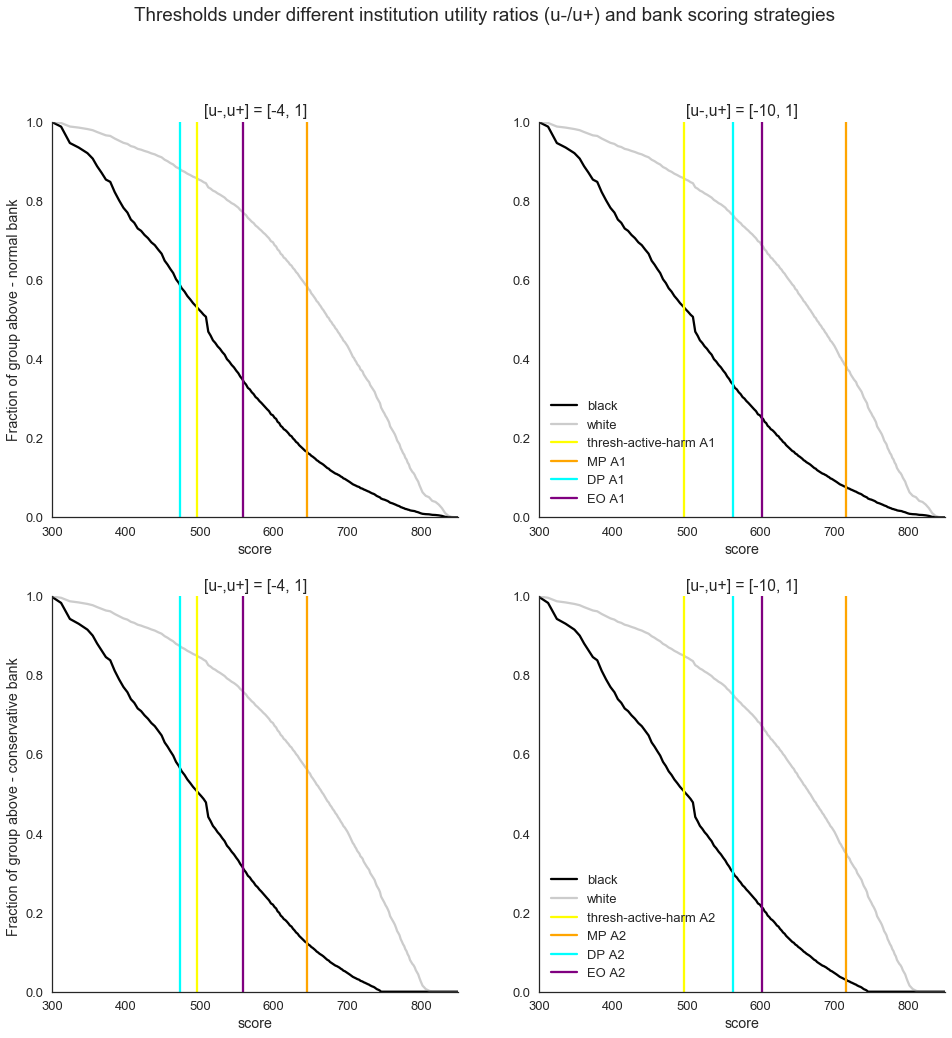

In [25]:
# plot the threshes
fig, ax = plt.subplots(2,len(threshes1),figsize=(16,16)); 
plt.title("")
for i,thresh in enumerate(threshes1):
    # unpack
    threshes_DP, threshes_EO, threshes_MP, threshes_downward = thresh
    ax[0,i].plot(scores, 1 - cdf_A1, label='black',color="black"); 
    ax[0,i].plot(scores,1 - cdf_B1, label='white',color="grey",alpha=0.4); 
    
    ax[0,i].set_xlabel("score")
    ax[0,i].axvline(threshes_downward[0],LineStyle='-', color='yellow',label="thresh-active-harm A1")
    ax[0,i].axvline(threshes_MP[0],LineStyle='-', color='orange',label="MP A1")
    ax[0,i].axvline(threshes_DP[0],LineStyle='-', color='cyan',label="DP A1")
    ax[0,i].axvline(threshes_EO[0],LineStyle='-', color='purple',label="EO A1")
    ax[0,i].set_title("[u-,u+] = {0}".format(util_repay[i]))
    ax[0,i].spines['right'].set_visible(False)
    ax[0,i].spines['top'].set_visible(False)
    ax[0,i].set_ylim([0,1])
    ax[0,i].set_xlim([300,850])

ax[0,1].legend(loc='lower left')
    
for i,thresh in enumerate(threshes2):
    # unpack
    threshes_DP, threshes_EO, threshes_MP, threshes_downward = thresh
    ax[1,i].plot(scores, 1 - cdf_A2, label='black',color="black"); 
    ax[1,i].plot(scores,1 - cdf_B2, label='white',color="grey",alpha=0.4); 
    
    ax[1,i].set_xlabel("score")
    ax[1,i].axvline(threshes_downward[0],LineStyle='-', color='yellow',label="thresh-active-harm A2")
    ax[1,i].axvline(threshes_MP[0],LineStyle='-', color='orange',label="MP A2")
    ax[1,i].axvline(threshes_DP[0],LineStyle='-', color='cyan',label="DP A2")
    ax[1,i].axvline(threshes_EO[0],LineStyle='-', color='purple',label="EO A2")
    ax[1,i].set_title("[u-,u+] = {0}".format(util_repay[i]))
    ax[1,i].spines['right'].set_visible(False)
    ax[1,i].spines['top'].set_visible(False)
    ax[1,i].set_ylim([0,1])
    ax[1,i].set_xlim([300,850])

plt.suptitle("Thresholds under different institution utility ratios (u-/u+) and bank scoring strategies")    
ax[0,0].set_ylabel("Fraction of group above - normal bank")
ax[1,0].set_ylabel("Fraction of group above - conservative bank ")
ax[1,1].legend(loc='lower left')


# Plot utility and outcome curves

In [26]:
# get outcome curves
outcome_curveA1 = dlo.get_outcome_curve(loan_repaid_probs[0],pis1[0],scores,impact)
outcome_curveB1 = dlo.get_outcome_curve(loan_repaid_probs[1],pis1[1],scores,impact)
outcome_curveA2 = dlo.get_outcome_curve(loan_repaid_probs[0],pis2[0],scores,impact)
outcome_curveB2 = dlo.get_outcome_curve(loan_repaid_probs[1],pis2[1],scores,impact)
outcome_curve_combined_A = dlo.get_outcome_curve(loan_repaid_probs[0],pis_combined[0],scores,impact)
outcome_curve_combined_B = dlo.get_outcome_curve(loan_repaid_probs[1],pis_combined[1],scores,impact)

rate_index_A1 = list(reversed(1- cdf_A1))
rate_index_B1 = list(reversed(1- cdf_B1))
rate_index_A2 = list(reversed(1- cdf_A2))
rate_index_B2 = list(reversed(1- cdf_B2))
rate_index_combined_A = list(reversed(1- cdf_combined_A))
rate_index_combined_B = list(reversed(1- cdf_combined_B))


In [27]:
# get utility curves
utility_curves1 = dlo.get_utility_curve(loan_repaid_probs,pis1, scores,utils=util_repay[0])
utility_curves2 = dlo.get_utility_curve(loan_repaid_probs,pis2, scores,utils=util_repay[0])
util_MP1 = np.amax(utility_curves1, axis=1)
util_MP2 = np.amax(utility_curves2, axis=1)

utility_curves_MP1 = np.vstack([utility_curves1[0] + util_MP1[1], utility_curves1[1]+ util_MP1[0]])
utility_curves_MP2 = np.vstack([utility_curves2[0] + util_MP2[1], utility_curves2[1]+ util_MP2[0]])
utility_curves_DP1 = dlo.get_utility_curves_dempar(utility_curves1,np.vstack(cdfs1),group_size_ratio, scores)
utility_curves_DP2 = dlo.get_utility_curves_dempar(utility_curves2,np.vstack(cdfs2),group_size_ratio, scores)
utility_curves_EO1 = dlo.get_utility_curves_eqopp(utility_curves1,loan_repaid_probs,pis1,group_size_ratio, scores)
utility_curves_EO2 = dlo.get_utility_curves_eqopp(utility_curves2,loan_repaid_probs,pis2,group_size_ratio, scores)

# get utility interest curves
utility_interest_curves1 = dlo.get_utility_interest_curve_range(loan_repaid_probs,pis1, scores, score_range, interest_range_normal_bank, utils=util_repay[0])
utility_interest_curves2 = dlo.get_utility_interest_curve_range(loan_repaid_probs,pis2, scores, score_range, interest_range_conservative_bank, utils=util_repay[0])
util_interest_MP1 = np.amax(utility_interest_curves1, axis=1)
util_interest_MP2 = np.amax(utility_interest_curves2, axis=1)

utility_interest_curves_MP1 = np.vstack([utility_interest_curves1[0] + util_interest_MP1[1], utility_interest_curves1[1]+ util_interest_MP1[0]])
utility_interest_curves_MP2 = np.vstack([utility_interest_curves2[0] + util_interest_MP2[1], utility_interest_curves2[1]+ util_interest_MP2[0]])
utility_interest_curves_DP1 = dlo.get_utility_curves_dempar(utility_interest_curves1,np.vstack(cdfs1),group_size_ratio, scores)
utility_interest_curves_DP2 = dlo.get_utility_curves_dempar(utility_interest_curves2,np.vstack(cdfs2),group_size_ratio, scores)
utility_interest_curves_EO1 = dlo.get_utility_curves_eqopp(utility_interest_curves1,loan_repaid_probs,pis1,group_size_ratio, scores)
utility_interest_curves_EO2 = dlo.get_utility_curves_eqopp(utility_interest_curves2,loan_repaid_probs,pis2,group_size_ratio, scores)


rate_index1 = [rate_index_A1, rate_index_B1]
rate_index2 = [rate_index_A2, rate_index_B2]
outcome_curves1 = [outcome_curveA1, outcome_curveB1]
outcome_curves2 = [outcome_curveA2, outcome_curveB2]
print("Position of curve extremes without and with interest rate")
for i in range(2):
    print("Optimum")
    print(np.max(outcome_curves1[i]), rate_index1[i][np.argmax(outcome_curves1[i])])
    print("MP")
    print(np.max(utility_curves_MP1[i]), rate_index1[i][np.argmax(utility_curves_MP1[i])])
    print(np.max(utility_interest_curves_MP1[i]), rate_index1[i][np.argmax(utility_interest_curves_MP1[i])] )

    print("DP")
    print(np.max(utility_curves_DP1[i]), rate_index1[i][np.argmax(utility_curves_DP1[i])])
    print(np.max(utility_interest_curves_DP1[i]), rate_index1[i][np.argmax(utility_interest_curves_DP1[i])] )
    
    print("EO")
    print(np.max(utility_curves_EO1[i]), rate_index1[i][np.argmax(utility_curves_EO1[i])])
    print(np.max(utility_interest_curves_EO1[i]), rate_index1[i][np.argmax(utility_interest_curves_EO1[i])] )
    print("")

Position of curve extremes without and with interest rate
Optimum
8.79562481895 0.2312
MP
0.56122665 0.1658
0.655005048795 0.1752
DP
0.32385054177 0.5124
0.382122196113 0.628
EO
0.411478066339 0.3415
0.478193962114 0.3707

Optimum
39.9263841414 0.7342
MP
0.56122665 0.6568
0.655005048795 0.6739
DP
0.32385054177 0.5134
0.383975164054 0.6203
EO
0.411478066339 0.6203
0.478193962114 0.6452



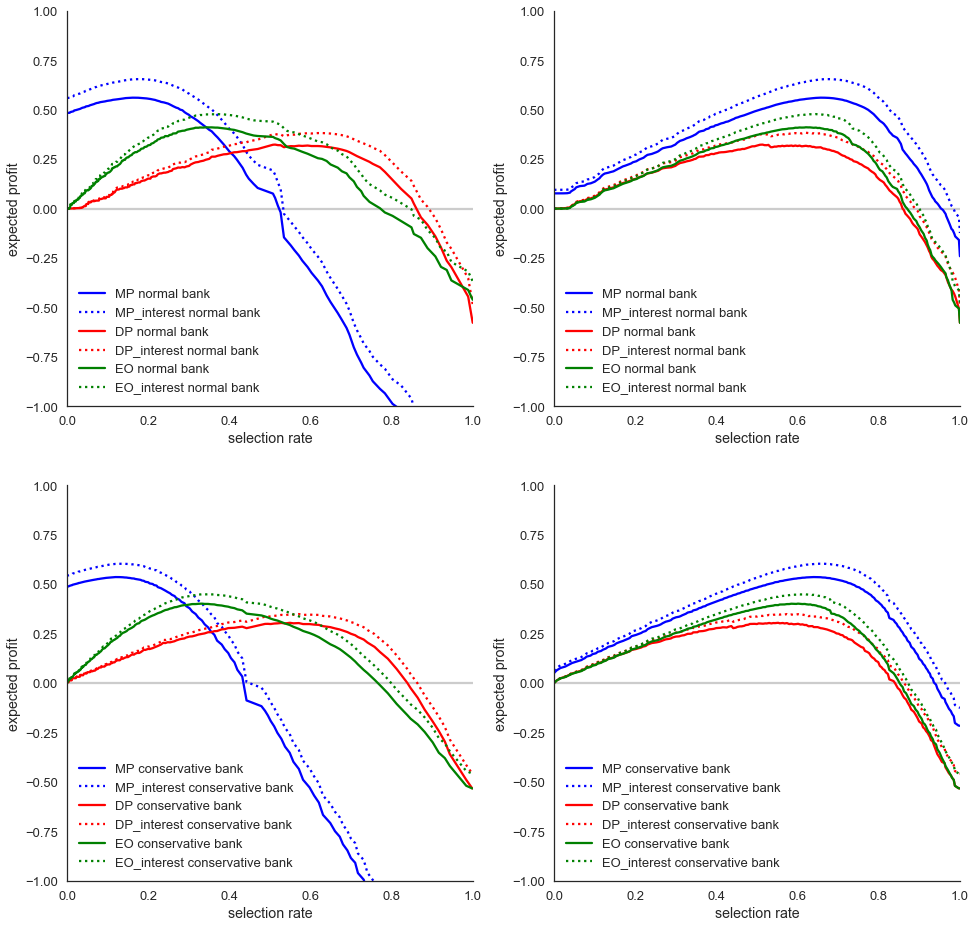

In [13]:
fig, ax = plt.subplots(2,2,figsize=(16,16)); 

for i in range(2):
    for j in range(2):
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].axhline(0,LineStyle='-', color='grey',alpha=0.4)
        
ax[0,0].plot(rate_index_A1, utility_curves_MP1[0], color="blue", label='MP normal bank');
ax[0,0].plot(rate_index_A1, utility_interest_curves_MP1[0], color="blue", label='MP_interest normal bank',LineStyle=':'); 
ax[0,0].plot(rate_index_A1, utility_curves_DP1[0], color="red", label='DP normal bank');
ax[0,0].plot(rate_index_A1, utility_interest_curves_DP1[0], color="red", label='DP_interest normal bank',LineStyle=':'); 
ax[0,0].plot(rate_index_A1, utility_curves_EO1[0], color="green", label='EO normal bank'); 
ax[0,0].plot(rate_index_A1, utility_interest_curves_EO1[0], color="green", label='EO_interest normal bank',LineStyle=':'); 
ax[0,0].set_xlabel('selection rate')
ax[0,0].set_ylabel('expected profit')
ax[0,0].set_ylim([-1,1])
ax[0,0].legend()
ax[0,0].set_xlim([0,1])

ax[0,1].plot(rate_index_B1, utility_curves_MP1[1], color="blue", label='MP normal bank'); 
ax[0,1].plot(rate_index_B1, utility_interest_curves_MP1[1], color="blue", label='MP_interest normal bank',LineStyle=':'); 
ax[0,1].plot(rate_index_B1, utility_curves_DP1[1], color="red", label='DP normal bank');
ax[0,1].plot(rate_index_B1, utility_interest_curves_DP1[1], color="red", label='DP_interest normal bank',LineStyle=':'); 
ax[0,1].plot(rate_index_B1, utility_curves_EO1[1], color="green", label='EO normal bank'); 
ax[0,1].plot(rate_index_B1, utility_interest_curves_EO1[1], color="green", label='EO_interest normal bank',LineStyle=':'); 
ax[0,1].set_xlabel('selection rate')
ax[0,1].set_ylabel('expected profit')
ax[0,1].set_ylim([-1,1])
ax[0,1].legend()
ax[0,1].set_xlim([0,1])

ax[1,0].plot(rate_index_A2, utility_curves_MP2[0], color="blue", label='MP conservative bank');
ax[1,0].plot(rate_index_A2, utility_interest_curves_MP2[0], color="blue", label='MP_interest conservative bank',LineStyle=':'); 
ax[1,0].plot(rate_index_A2, utility_curves_DP2[0], color="red", label='DP conservative bank');
ax[1,0].plot(rate_index_A2, utility_interest_curves_DP2[0], color="red", label='DP_interest conservative bank',LineStyle=':'); 
ax[1,0].plot(rate_index_A2, utility_curves_EO2[0], color="green", label='EO conservative bank'); 
ax[1,0].plot(rate_index_A2, utility_interest_curves_EO2[0], color="green", label='EO_interest conservative bank',LineStyle=':'); 
ax[1,0].set_xlabel('selection rate')
ax[1,0].set_ylabel('expected profit')
ax[1,0].set_ylim([-1,1])
ax[1,0].legend()
ax[1,0].set_xlim([0,1])

ax[1,1].plot(rate_index_B2, utility_curves_MP2[1], color="blue", label='MP conservative bank'); 
ax[1,1].plot(rate_index_B2, utility_interest_curves_MP2[1], color="blue", label='MP_interest conservative bank',LineStyle=':'); 
ax[1,1].plot(rate_index_B2, utility_curves_DP2[1], color="red", label='DP conservative bank');
ax[1,1].plot(rate_index_B2, utility_interest_curves_DP2[1], color="red", label='DP_interest conservative bank',LineStyle=':'); 
ax[1,1].plot(rate_index_B2, utility_curves_EO2[1], color="green", label='EO conservative bank'); 
ax[1,1].plot(rate_index_B2, utility_interest_curves_EO2[1], color="green", label='EO_interest conservative bank',LineStyle=':'); 
ax[1,1].set_xlabel('selection rate')
ax[1,1].set_ylabel('expected profit')
ax[1,1].set_ylim([-1,1])
ax[1,1].legend()
ax[1,1].set_xlim([0,1])
plt.suptitle("")


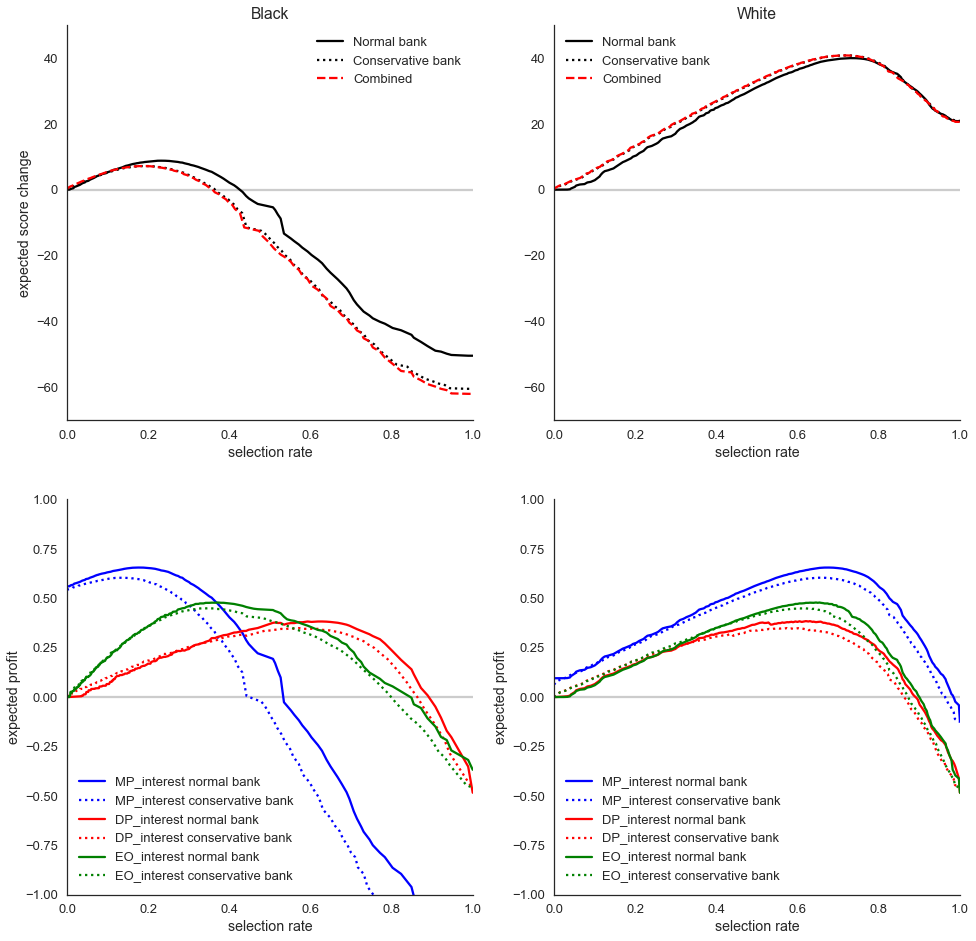

In [14]:
fig, ax = plt.subplots(2,2,figsize=(16,16)); 

for i in range(2):
    for j in range(2):
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].axhline(0,LineStyle='-', color='grey',alpha=0.4)
        
ax[0,0].plot(rate_index_A1,outcome_curveA1,color='black',label='Normal bank')
ax[0,0].plot(rate_index_A2,outcome_curveA2,color='black',LineStyle=':', label='Conservative bank')
ax[0,0].plot(rate_index_combined_A,outcome_curve_combined_A,color='red',LineStyle='--', label='Combined')
ax[0,0].set_xlabel('selection rate');
ax[0,0].set_ylabel('expected score change')
ax[0,0].set_title('Black'); 
ax[0,0].set_ylim([-70,50])
ax[0,0].set_xlim([0,1])
ax[0,0].legend()

ax[0,1].plot(rate_index_B1,outcome_curveB1,color='black',label='Normal bank')
ax[0,1].plot(rate_index_B2,outcome_curveB2,color='black',LineStyle=':', label='Conservative bank')
ax[0,1].plot(rate_index_combined_B,outcome_curve_combined_B,color='red',LineStyle='--', label='Combined')
ax[0,1].set_xlabel('selection rate')
ax[0,1].set_title('White') 
ax[0,1].set_ylim([-70,50])
ax[0,1].set_xlim([0,1])
ax[0,1].legend()

ax[1,0].plot(rate_index_A1, utility_interest_curves_MP1[0], color='blue', label='MP_interest normal bank'); 
ax[1,0].plot(rate_index_A2, utility_interest_curves_MP2[0], color='blue', label='MP_interest conservative bank', LineStyle=':'); 
ax[1,0].plot(rate_index_A1, utility_interest_curves_DP1[0], color='red', label='DP_interest normal bank'); 
ax[1,0].plot(rate_index_A2, utility_interest_curves_DP2[0], color='red', label='DP_interest conservative bank',LineStyle=':'); 
ax[1,0].plot(rate_index_A1, utility_interest_curves_EO1[0], color='green', label='EO_interest normal bank'); 
ax[1,0].plot(rate_index_A2, utility_interest_curves_EO2[0], color='green', label='EO_interest conservative bank',LineStyle=':'); 
ax[1,0].set_xlabel('selection rate')
ax[1,0].set_ylabel('expected profit')
ax[1,0].set_ylim([-1,1])
ax[1,0].legend()
ax[1,0].set_xlim([0,1])

ax[1,1].plot(rate_index_B1, utility_interest_curves_MP1[1], color='blue', label='MP_interest normal bank'); 
ax[1,1].plot(rate_index_B2, utility_interest_curves_MP2[1], color='blue', label='MP_interest conservative bank',LineStyle=':'); 
ax[1,1].plot(rate_index_B1, utility_interest_curves_DP1[1], color='red', label='DP_interest normal bank'); 
ax[1,1].plot(rate_index_B2, utility_interest_curves_DP2[1], color='red', label='DP_interest conservative bank',LineStyle=':'); 
ax[1,1].plot(rate_index_B1, utility_interest_curves_EO1[1], color='green', label='EO_interest normal bank'); 
ax[1,1].plot(rate_index_B2, utility_interest_curves_EO2[1], color='green', label='EO_interest conservative bank',LineStyle=':'); 
ax[1,1].set_xlabel('selection rate')
ax[1,1].set_ylabel('expected profit')
ax[1,1].set_ylim([-1,1])
ax[1,1].legend()
ax[1,1].set_xlim([0,1])
plt.suptitle("")



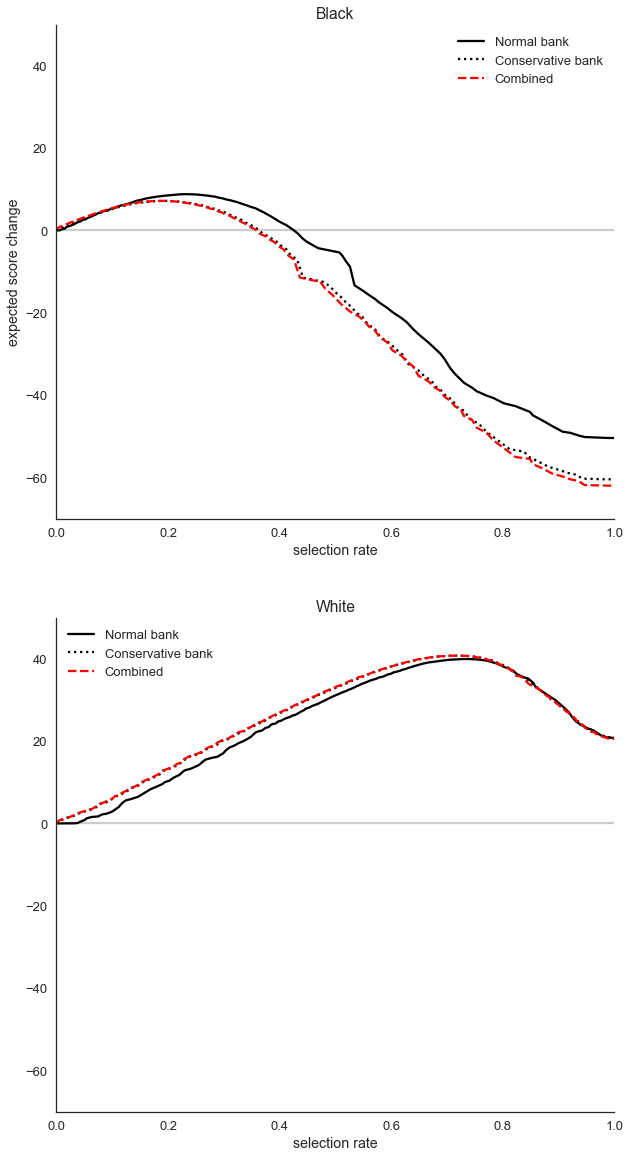

In [15]:
fig, ax = plt.subplots(2,1,figsize=(10,20)); 
for i in range(2):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].axhline(0,LineStyle='-', color='grey',alpha=0.4)

        
ax[0].plot(rate_index_A1,outcome_curveA1,color='black',label='Normal bank')
ax[0].plot(rate_index_A2,outcome_curveA2,color='black',LineStyle=':', label='Conservative bank')
ax[0].plot(rate_index_combined_A,outcome_curve_combined_A,color='red',LineStyle='--', label='Combined')
ax[0].set_xlabel('selection rate');
ax[0].set_ylabel('expected score change')
ax[0].set_title('Black'); 
ax[0].set_ylim([-70,50])
ax[0].set_xlim([0,1])
ax[0].legend()

ax[1].plot(rate_index_B1,outcome_curveB1,color='black',label='Normal bank')
ax[1].plot(rate_index_B2,outcome_curveB2,color='black',LineStyle=':', label='Conservative bank')
ax[1].plot(rate_index_combined_B,outcome_curve_combined_B,color='red',LineStyle='--', label='Combined')
ax[1].set_xlabel('selection rate')
ax[1].set_title('White') 
ax[1].set_ylim([-70,50])
ax[1].set_xlim([0,1])
ax[1].legend()